<a href="https://colab.research.google.com/github/bhanudeergasi/NullClass_Data_science_internship/blob/main/model_training2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# === TASK2 CGAN Notebook ===


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [5]:
# 2. Create folder in Drive to save models
base_path = '/content/drive/MyDrive/TASK2'
os.makedirs(base_path, exist_ok=True)
print(f"Models and files will be saved in: {base_path}")

Models and files will be saved in: /content/drive/MyDrive/TASK2


In [6]:
# 3. Generate synthetic dataset (circles, squares, triangles)
def generate_shape(shape, img_size=28):
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    thickness = -1  # filled shape
    color = 255
    if shape == 'circle':
        cv2.circle(img, (img_size//2, img_size//2), img_size//3, color, thickness)
    elif shape == 'square':
        side = img_size//2
        top_left = (img_size//2 - side//2, img_size//2 - side//2)
        bottom_right = (img_size//2 + side//2, img_size//2 + side//2)
        cv2.rectangle(img, top_left, bottom_right, color, thickness)
    elif shape == 'triangle':
        pts = np.array([
            [img_size//2, img_size//6],
            [img_size//6, img_size*5//6],
            [img_size*5//6, img_size*5//6]
        ])
        cv2.drawContours(img, [pts], 0, color, thickness)
    return img

shapes = ['circle', 'square', 'triangle']
num_samples_per_class = 1000
img_size = 28

all_imgs = []
all_labels = []

for label, shape in enumerate(shapes):
    for _ in range(num_samples_per_class):
        all_imgs.append(generate_shape(shape, img_size))
        all_labels.append(label)

all_imgs = np.array(all_imgs) / 255.0  # Normalize to [0,1]
all_labels = np.array(all_labels)

# Train-test split
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    all_imgs, all_labels, test_size=0.2, random_state=42)

train_tensor = torch.tensor(train_imgs).unsqueeze(1).float()
train_labels_tensor = torch.tensor(train_labels)
test_tensor = torch.tensor(test_imgs).unsqueeze(1).float()
test_labels_tensor = torch.tensor(test_labels)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_tensor, test_labels_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
# 4. Define CGAN models
latent_dim = 100
num_classes = len(shapes)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Linear(512, img_size*img_size),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        out = self.model(x)
        out = out.view(out.size(0), 1, img_size, img_size)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(img_size*img_size + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        img_flat = img.view(img.size(0), -1)
        x = torch.cat([img_flat, c], 1)
        validity = self.model(x)
        return validity

generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [8]:
# 5. Training CGAN
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 50

for epoch in range(epochs):
    generator.train()
    discriminator.train()
    g_loss_epoch = 0
    d_loss_epoch = 0

    for imgs, labels in train_loader:
        batch_size_curr = imgs.size(0)
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size_curr, 1, device=device)
        fake = torch.zeros(batch_size_curr, 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size_curr,), device=device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

    print(f"Epoch [{epoch+1}/{epochs}]  Generator Loss: {g_loss_epoch/len(train_loader):.4f}  Discriminator Loss: {d_loss_epoch/len(train_loader):.4f}")

Epoch [1/50]  Generator Loss: 0.6625  Discriminator Loss: 0.5254
Epoch [2/50]  Generator Loss: 1.1399  Discriminator Loss: 0.3418
Epoch [3/50]  Generator Loss: 1.2761  Discriminator Loss: 0.3407
Epoch [4/50]  Generator Loss: 1.8731  Discriminator Loss: 0.1955
Epoch [5/50]  Generator Loss: 2.1200  Discriminator Loss: 0.1637
Epoch [6/50]  Generator Loss: 2.3764  Discriminator Loss: 0.1604
Epoch [7/50]  Generator Loss: 2.4347  Discriminator Loss: 0.1380
Epoch [8/50]  Generator Loss: 2.8596  Discriminator Loss: 0.1758
Epoch [9/50]  Generator Loss: 2.6318  Discriminator Loss: 0.1705
Epoch [10/50]  Generator Loss: 2.7045  Discriminator Loss: 0.1139
Epoch [11/50]  Generator Loss: 3.2719  Discriminator Loss: 0.2495
Epoch [12/50]  Generator Loss: 2.3741  Discriminator Loss: 0.2121
Epoch [13/50]  Generator Loss: 2.9487  Discriminator Loss: 0.2357
Epoch [14/50]  Generator Loss: 2.4432  Discriminator Loss: 0.3380
Epoch [15/50]  Generator Loss: 2.6349  Discriminator Loss: 0.2361
Epoch [16/50]  Gene

In [9]:
# 6. Save models to Drive
torch.save(generator.state_dict(), os.path.join(base_path, "generator.pth"))
torch.save(discriminator.state_dict(), os.path.join(base_path, "discriminator.pth"))
print("Models saved successfully!")

Models saved successfully!


In [10]:
# 7. Define a simple CNN classifier to evaluate generated images
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

classifier = SimpleCNN().to(device)
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier.parameters(), lr=0.001)

In [11]:
# 8. Train classifier on real images
epochs_cls = 10
for epoch in range(epochs_cls):
    classifier.train()
    running_loss = 0
    for imgs_batch, lbls_batch in train_loader:
        imgs_batch, lbls_batch = imgs_batch.to(device), lbls_batch.to(device)
        optimizer_cls.zero_grad()
        outputs = classifier(imgs_batch)
        loss = criterion_cls(outputs, lbls_batch)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item()
    print(f"Classifier Epoch {epoch+1}/{epochs_cls} Loss: {running_loss/len(train_loader):.4f}")

Classifier Epoch 1/10 Loss: 0.4161
Classifier Epoch 2/10 Loss: 0.0013
Classifier Epoch 3/10 Loss: 0.0003
Classifier Epoch 4/10 Loss: 0.0002
Classifier Epoch 5/10 Loss: 0.0001
Classifier Epoch 6/10 Loss: 0.0001
Classifier Epoch 7/10 Loss: 0.0000
Classifier Epoch 8/10 Loss: 0.0000
Classifier Epoch 9/10 Loss: 0.0000
Classifier Epoch 10/10 Loss: 0.0000


In [12]:
# 9. Evaluate classifier on generated images
generator.eval()
classifier.eval()

gen_labels = []
gen_preds = []

with torch.no_grad():
    for label in range(num_classes):
        label_tensor = torch.full((50,), label, dtype=torch.long, device=device)
        z = torch.randn(50, latent_dim, device=device)
        gen_imgs = generator(z, label_tensor)
        outputs = classifier(gen_imgs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        gen_labels.extend([label]*50)
        gen_preds.extend(preds)

acc = accuracy_score(gen_labels, gen_preds)
prec = precision_score(gen_labels, gen_preds, average='weighted')
rec = recall_score(gen_labels, gen_preds, average='weighted')
f1 = f1_score(gen_labels, gen_preds, average='weighted')

print(f"\nEvaluation on generated images:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluation on generated images:
Accuracy: 0.9000
Precision: 0.9231
Recall: 0.9000
F1 Score: 0.8989


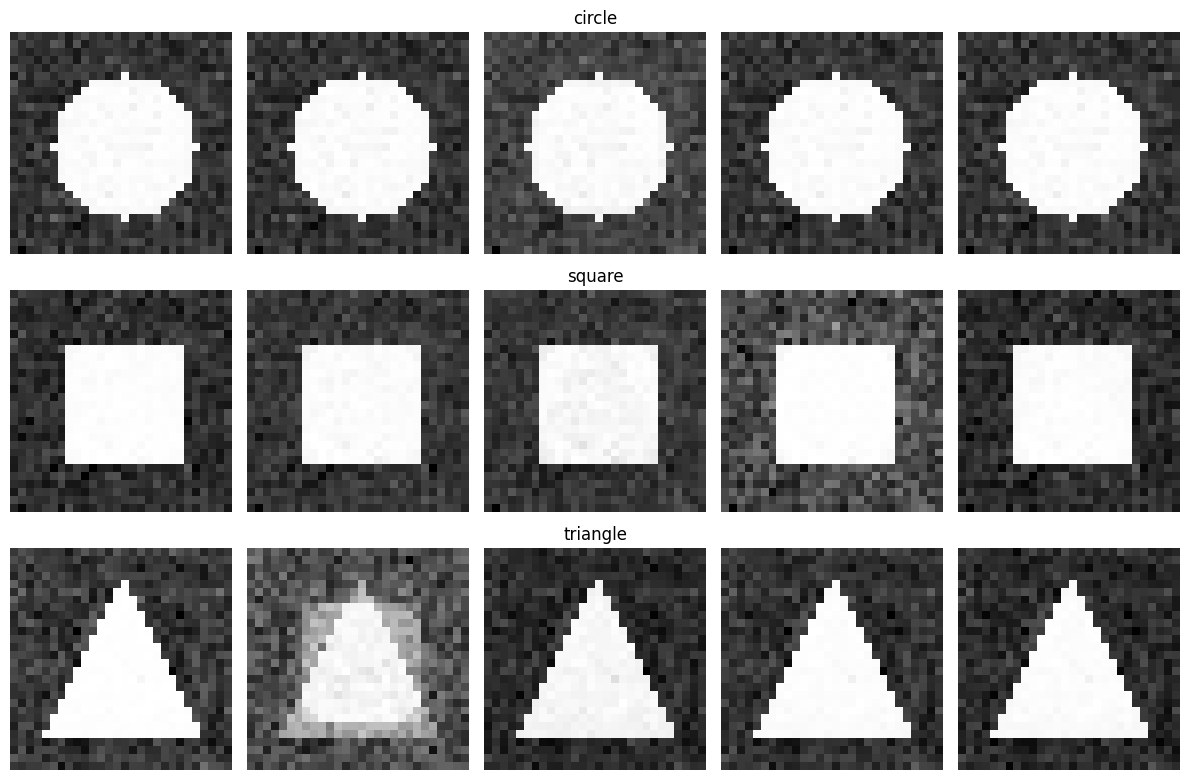

In [13]:
# 10. Visualize generated images
fig, axs = plt.subplots(num_classes, 5, figsize=(12,8))
for i in range(num_classes):
    label_tensor = torch.full((5,), i, dtype=torch.long, device=device)
    z = torch.randn(5, latent_dim, device=device)
    gen_imgs = generator(z, label_tensor).cpu()
    for j in range(5):
        # Detach the tensor before converting to NumPy for visualization
        axs[i,j].imshow(gen_imgs[j][0].detach() * 0.5 + 0.5, cmap='gray')
        axs[i,j].axis('off')
        if j == 2:
            axs[i,j].set_title(shapes[i])
plt.tight_layout()
plt.show()